# POPPY Simulation: UA Wavefront Testbed (Phase 1, no optics surfaces)
## Notes:
- <b>Testbed Design Version</b>: 2016/09/26, Kelsey Miller. See data/Testbed_Layout_Schematic_Oct_2016.pdf for additional details.
- This notebook only models phase 1, which replaces OAP4 with the characteristics of OAP1/2/3. There are some angle changes and additional optics in place not shown in the design.
- This version has no surface maps implemented. It is meant as a reference to show that the testbed layout does work. There will be a separate file version with the surface maps implemented.
- This notebook calculates the F/# focal plane generation to make any distance corrections.
- The testbed uses a diverging beam source, so this notebook "fakes" it in with a negative lens.

In [44]:
%matplotlib inline
import numpy as np

# plotting tools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib

# units
from astropy import units as u
from astropy.io import fits

# POPPY
import poppy
from poppy.poppy_core import PlaneType
poppy.__version__

'0.6.0rc1'

## Initiate the optical elements and variables
### Optical elements not implemented:
- vAPP mask (placement missing)
- MagAOX Pupil (placement missing)
- BMC 1K DM powered flat surface
- IrisAO DM powered flat surface

### Assumptions made:
- Deformable mirrors (Iris AO, BMC 1K) are implemented as regular mirrors. 

### Other missing data:
- Collimating lens placement (preferrably from second F/39 focal plane)
- vAPP mask placement (needs distance from collimating lens)
- Are there any additional optics between vAPP mask and camera?

In [45]:
# define system parameters
EP_diam = 0.007 * u.m # 7mm beam diameter used as entrance pupil
oversamp = 0.125
samp = 256

halpha = 656e-9 * u.m

# define physical sizes
oap_radius = 0.254 * u.m # 2 inch diameter
irisAO_radius = 0.254 * u.m # don't know size, going to assume 2 inch diameter
BMC1K_radius = 0.254 * u.m # also don't know size, but it's large enough
colLens_radius = 0.254 * u.m # I think it's a 2 inch diameter

# define focal lengths
fl_OAP = 0.273 * u.m # all OAPs are the same focal length
fl_colLens = 0.350 * u.m # kelsey defined

# define distances
d_src_oap1 = 0.273 * u.m
d_oap1_irisAO = 0.273 *u.m
d_irisAO_oap2 = 0.273 * u.m
d_oap2_f39 = 0.273 * u.m
d_f39_oap3 = 0.273 * u.m
d_oap3_BMC1K = 0.273 * u.m
d_BMC1K_oap4 = 0.273 * u.m
d_oap4_f39 = 0.273 * u.m
d_f39_colLens = 0.350 * u.m 
# ASSUMPTION: placing collimating lens a focal plane away from F/39 to make afocal system

# initialize optical elements
diverge_source = poppy.QuadraticLens(-(d_src_oap1),name='diverging source') 
# finite distance source is a negative lens to simulate dispersive source
colLens = poppy.QuadraticLens(fl_colLens, name='Collimating Lens')

# Declare OAP mirrors
OAP1 = poppy.QuadraticLens(fl_OAP, name='OAP-1')
OAP2 = poppy.QuadraticLens(fl_OAP, name='OAP-2')
OAP3 = poppy.QuadraticLens(fl_OAP, name='OAP-3')
OAP4 = poppy.QuadraticLens(fl_OAP, name='OAP-4')

### Function surfFITS: Initiates a FITS file to add to optical system
#### Parameters:
- file_loc (string): path location of FITS file
- optic_type (string): Declare if the file is OPD or Transmission type ('opd' or 'trans')
- opdunit (string): OPD units of FITS file. For some reason, the BUNIT header card gives errors, so need to declare manually.
- name (string): descriptive name for optic. Useful for the phase description.

#### Sequence of initializing:
- Call in FITS file
- Typecast FITS data to float (workaround to get POPPY to accept FITS data)
- Determine optic type to choose how to build FITSOpticalElement
- Return FITSOpticalElement object

#### Reference:
https://pythonhosted.org/poppy/api/poppy.FITSOpticalElement.html

In [ ]:
def surfFITS(file_loc, optic_type, opdunit, name):
    optic_fits = fits.open(file_loc)
    optic_fits[0].data = np.float_(optic_fits[0].data) # typecasting
    if optic_type == 'opd':
        optic_surf = poppy.FITSOpticalElement(name = name, opd=optic_fits, opdunits = opdunit)
    else:
        optic_surf = poppy.FITSOpticalElement(name = name, transmission=optic_fits)
    return optic_surf

Pass in all the required surfaces from FITS files

In [ ]:
pupil = surfFITS(file_loc='data/MagAOX_f11_pupil_256_unmasked.fits', optic_type='trans', opdunit='none', 
                 name='MagAO-X Pupil (unmasked)')

# Build Testbed optical system to first F/39 focal plane

In [46]:
# Initialize FresnelOpticalSystem
uawfstb = poppy.FresnelOpticalSystem(pupil_diameter = EP_diam, npix=samp, beam_ratio=oversamp)

# First surface is the entrance aperture.
uawfstb.add_optic(poppy.CircularAperture(radius=EP_diam/2)) # not sure why multiplying by 0.4?

# To simulate a diverging pt source, use a negative-power lens with focal length -d, 
# where d is distance prior to entrance aperture
uawfstb.add_optic(diverge_source)

# Add in OAP1
uawfstb.add_optic(OAP1) # I don't understand why, but there doesn't need to be a distance here. 
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP1 radius"))
# Light should be collimated at this point

# Add in IrisAO DM, just a "perfect" mirror
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="IrisAO DM"), 
                                            distance=d_oap1_irisAO)
uawfstb.add_optic(poppy.CircularAperture(radius=irisAO_radius,name="IrisAO aperture"))

# add in OAP2
uawfstb.add_optic(OAP2, distance=d_irisAO_oap2)
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP2 aperture"))
# Light should be converging at this point

# Add in F/39 focal plane
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/39 focal plane"), 
                                            distance=d_oap2_f39)

/home/jhen/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:858: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


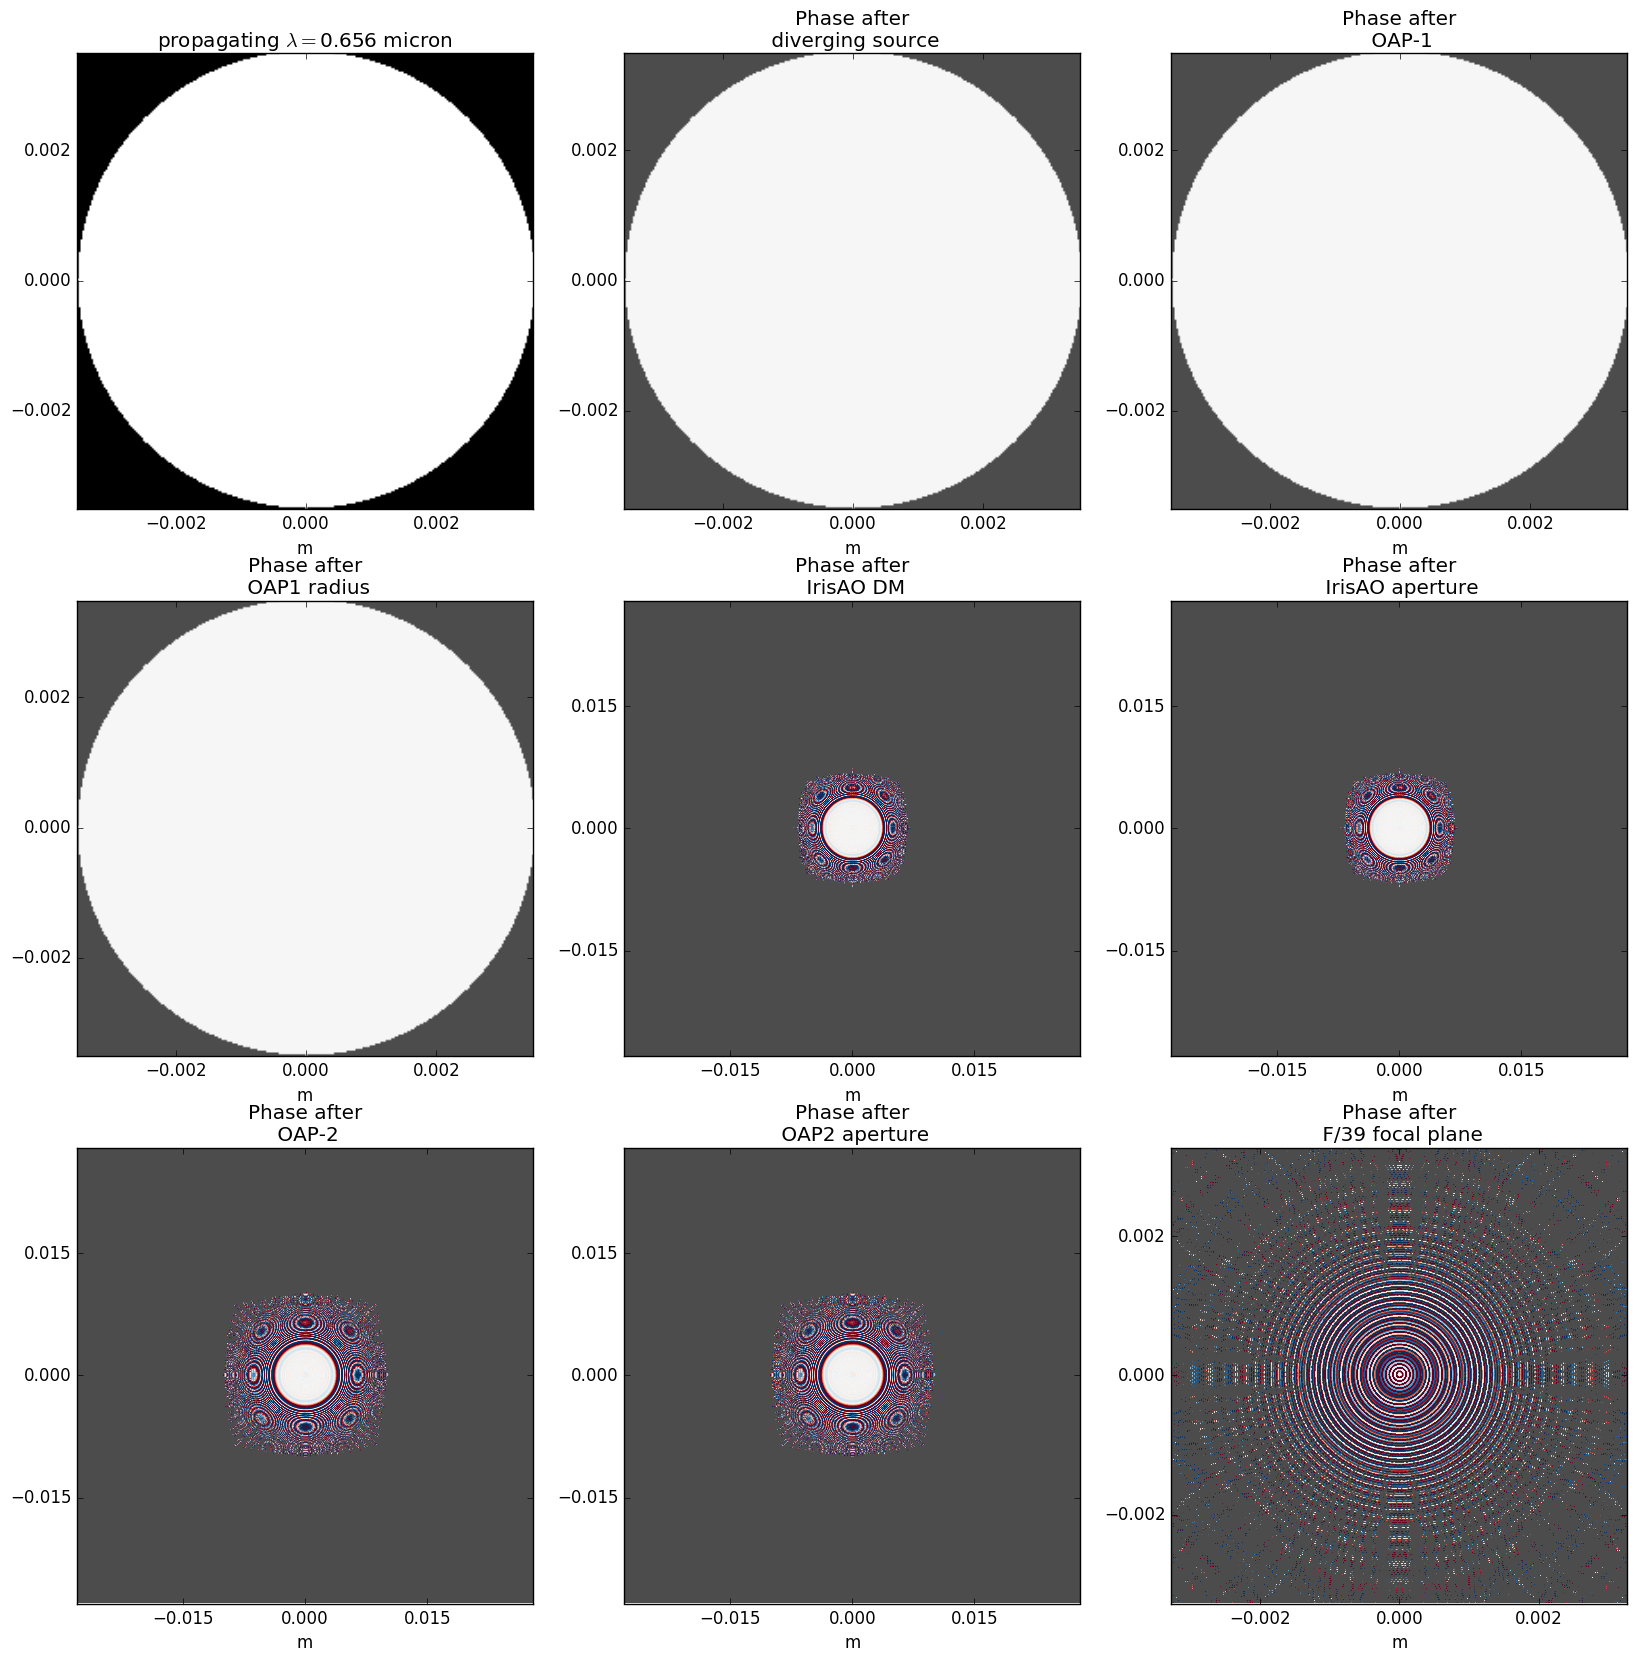

In [47]:
matplotlib.rcParams["font.size"]=12
plt.figure(figsize=[20,20])
f39_psf, f39_wfs = uawfstb.calcPSF(wavelength=halpha, 
                                        display_intermediates=True, 
                                        return_intermediates=True)

The phase at F/39 looks like it's converging, so that means the diverging source is working!

But, does the F/39 need a distance correction? Let's check.

In [48]:
# Focal plane correction for F/39
unfixed_f39fp_psf, unfixed_f39fp_wfs = uawfstb.calcPSF(wavelength=halpha, display_intermediates=False, return_intermediates=True)
f39_last_wave = unfixed_f39fp_wfs[-1]
f39_delta = f39_last_wave.z_w0 - f39_last_wave.z #f39_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/39 PSF.
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/39 focal plane (corrected)"), distance=f39_delta)

/home/jhen/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:858: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


In [49]:
f39_delta

<Quantity -5.911725939333756e-06 m>

The distance is really small! I'll add it in the correction distance for the CSV file.

In [50]:
# add in OAP3
uawfstb.add_optic(OAP3, distance=d_f39_oap3)
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP3 aperture"))
# Light should be collimated at this point

# Add in BMC 1K DM, just a "perfect" mirror
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="BMC 1K DM"), 
                                            distance=d_oap3_BMC1K)
uawfstb.add_optic(poppy.CircularAperture(radius=BMC1K_radius,name="BMC 1K DM aperture"))

# add in OAP4
uawfstb.add_optic(OAP2, distance=d_BMC1K_oap4)
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP4 aperture"))
# Light should be converging at this point

# Add in second F/39 focal plane
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="Second F/39 focal plane"), 
                                            distance=d_oap4_f39)


Calculating correction distance for second F/39

In [51]:
# Focal plane correction for F/39
unfixed_f39fp2_psf, unfixed_f39fp2_wfs = uawfstb.calcPSF(wavelength=halpha, display_intermediates=False, return_intermediates=True)
f39fp2_last_wave = unfixed_f39fp2_wfs[-1]
f39fp2_delta = f39fp2_last_wave.z_w0 - f39fp2_last_wave.z #f39_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/39 PSF.
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="Second F/39 focal plane (corrected)"), distance=f39fp2_delta)

/home/jhen/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:858: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


In [52]:
f39fp2_delta

<Quantity -5.911213912357383e-06 m>

Add in collimating lens to make a pupil plane for vAPP

In [53]:
# Add in collimating lens for vAPP mask
uawfstb.add_optic(colLens, distance=d_f39_colLens)
uawfstb.add_optic(poppy.CircularAperture(radius=colLens_radius,name="collimating lens aperture"))
# Light should be collimating at this point

# Add in vAPP mask here, but I don't know the distance, so ignoring for now

# Add in the location of the camera, just to show that the beam coming into the camera is collimated.
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="Science Camera"), 
                                            distance=0.05 * u.m) # 50mm distance from colLens

/home/jhen/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:858: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


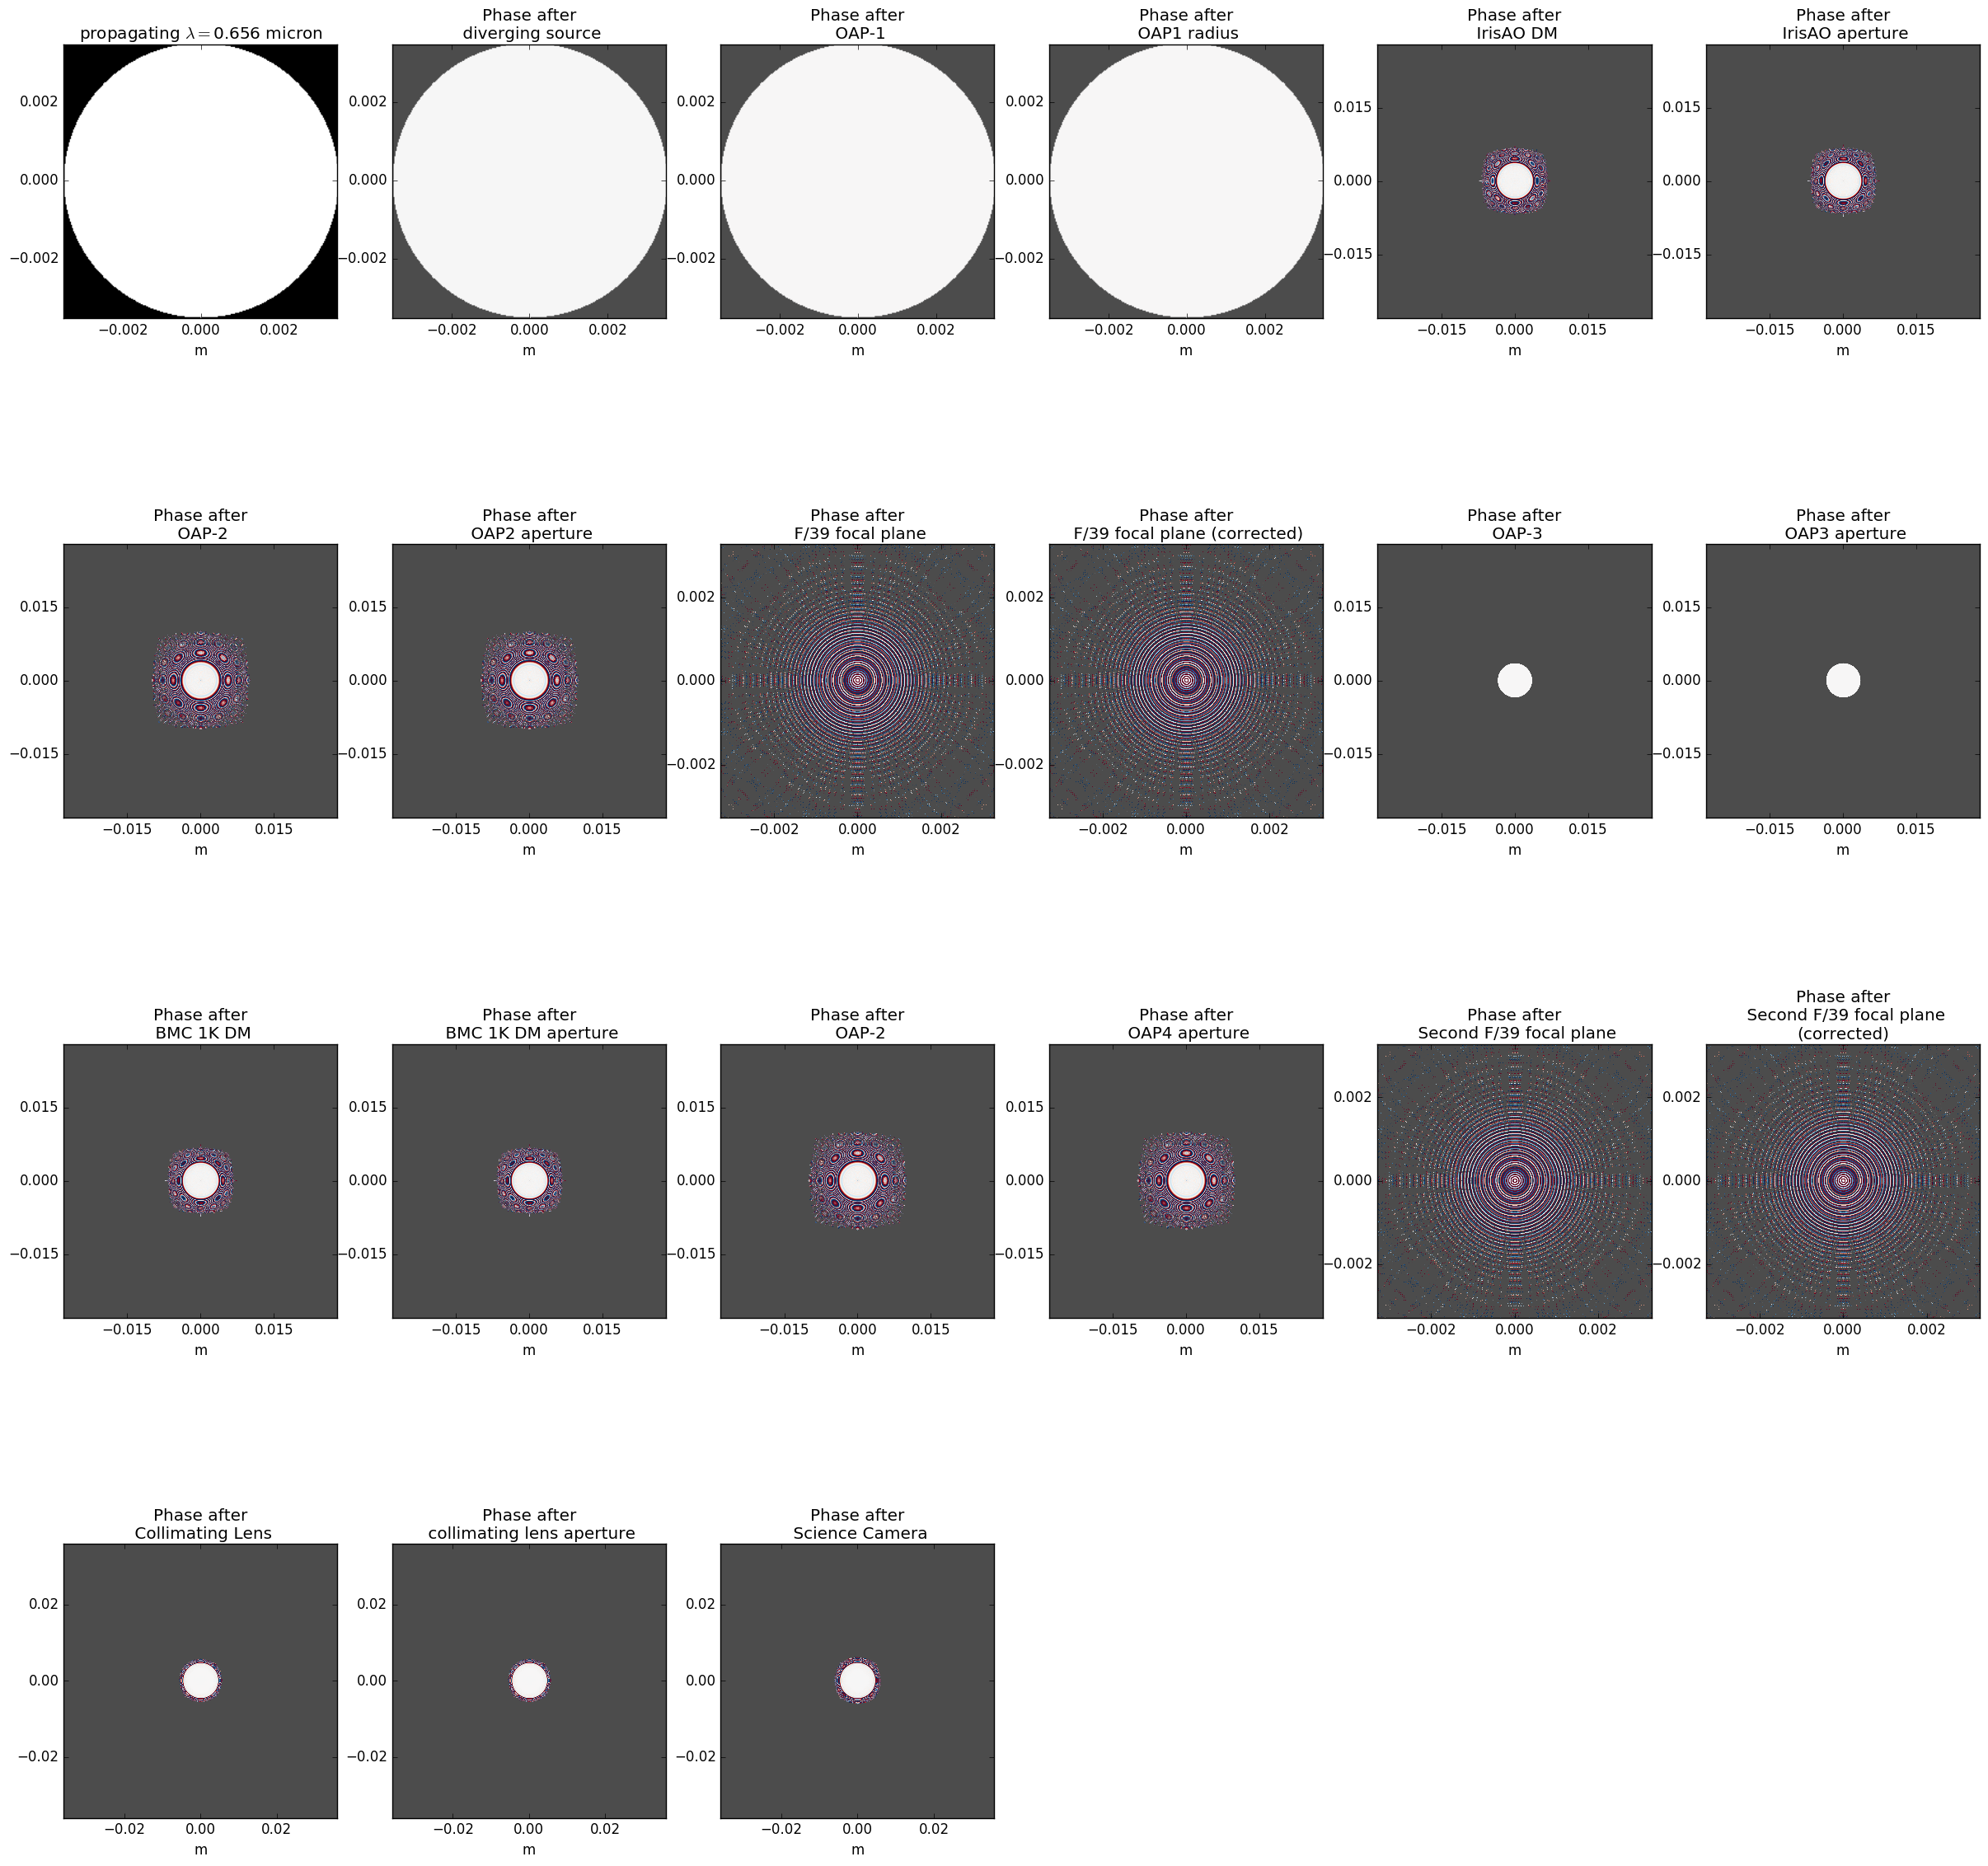

In [54]:
matplotlib.rcParams["font.size"]=12
plt.figure(figsize=[30,30])
pplane_psf, pplane_wfs = uawfstb.calcPSF(wavelength=halpha, 
                                        display_intermediates=True, 
                                        return_intermediates=True)

Looks like the beam is collimating and converging at the right locations! So things are going well.